In [3]:
%matplotlib inline

In [4]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [5]:
PATH = "./"

In [6]:
!ls {PATH}

'Airfoil Data.ipynb'	      'Predict Shop Price.ipynb'
'Basic Random Forests.ipynb'   Train.csv


In [7]:
df_raw = pd.read_csv(f'{PATH}Train.csv', low_memory=False, parse_dates=['saledate'])

In [8]:
def display_all(df):
    '''
    Display a maximum of 1000 rows and columns without truncation
    '''
    with pd.option_context("display.max_rows", 1000):
        with pd.option_context("display.max_columns", 1000):
            display(df)

In [9]:
display_all(df_raw.tail().transpose())

,401120,401121,401122,401123,401124
SalesID,6333336,6333337,6333338,6333341,6333342
SalePrice,10500,11000,11500,9000,7750
MachineID,1840702,1830472,1887659,1903570,1926965
ModelID,21439,21439,21439,21435,21435
datasource,149,149,149,149,149
auctioneerID,1,1,1,2,2
YearMade,2005,2005,2005,2005,2005
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-10-25 00:00:00,2011-10-25 00:00:00


<b> Contest calculates score on log scale </b>

In [10]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

m = RandomForestRegressor(n_jobs = -1)
m.fit(df_raw.drop('Saleprice',axis=1), df_raw.SalePrice)

In [11]:
os.makedirs('tmp',exist_ok=True)
#Save dataframe to disk from RAM
df_raw.to_feather('tmp/raw')

In [12]:
#Add actionable insights from datefield to the dataframe:
add_datepart(df_raw, 'saledate')

In [13]:
#Make categorical strings into numerical categories
train_cats(df_raw)

In [14]:
#Change order of categories assigned
df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)

In [15]:
#The above command changes the internal representation
#To change it in the displayed df:
df_raw.UsageBand = df_raw.UsageBand.cat.codes

In [16]:
#Drop variable from dataset and make all values numerical
#Do this after train_cat
df, y, nas = proc_df(df_raw, 'SalePrice')

In [17]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df, y)
m.score(df,y)

/home/orange/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9830556300008132

In [19]:
def split_vals(X,n): return X[:n].copy(), X[n:].copy()

size_validation = 12000
size_train = len(df) - size_validation
x_train, x_valid = split_vals(df, size_train)
y_train, y_valid = split_vals(y, size_train)


In [24]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(x_train),y_train), rmse(m.predict(x_valid),y_valid),
          m.score(x_train,y_train), m.score(x_valid,y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [25]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(x_train, y_train)
print_score(m)

/home/orange/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.09042899739469212, 0.24925671945522385, 0.9829096775189948, 0.8890463167767191]


Take a subset of the training data if it takes too much compute time

In [41]:
df_train, y_train , _= proc_df(df_raw, 'SalePrice', subset=30000)
x_train, _ = split_vals(df_train, 20000)
y_train, _ = split_vals(y_train, 20000)

In [43]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(x_train, y_train)
print_score(m)

/home/orange/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 3.25 s, sys: 9.62 ms, total: 3.26 s
Wall time: 1.17 s
[0.11165588518652138, 0.36410149651573437, 0.9728897561037244, 0.7632484113412898]


In [48]:
#Single Tree
m = RandomForestRegressor(n_estimators=1, n_jobs=-1, max_depth=3, bootstrap=False)
m.fit(x_train, y_train)
print_score(m)

[0.52558718456482, 0.5800646677850463, 0.3992971099804956, 0.3991019425294924]


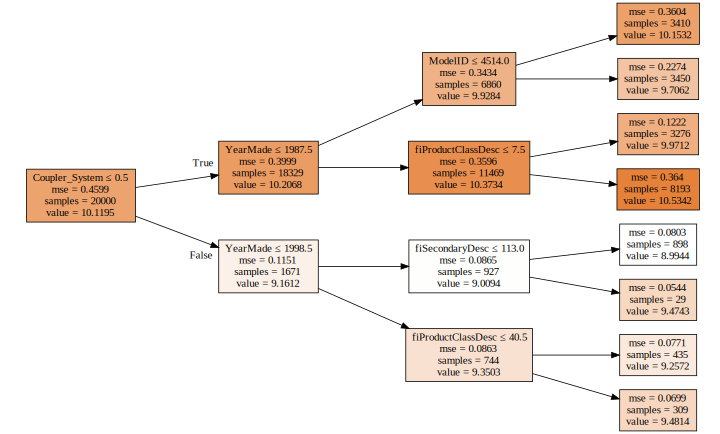

In [46]:
draw_tree(m.estimators_[0], df_train, precision=4)

In [51]:
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(x_train, y_train)
print_score(m)

[3.1568979266172195e-06, 0.4768424267687133, 0.9999999999783282, 0.5939329475266291]


Bagging : Overfit Trees to diff samples and take the average

In [52]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(x_train, y_train)
print_score(m)

/home/orange/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.11057448553255568, 0.3713236107949257, 0.9734123445741468, 0.7537631176428702]


In [54]:
df_trn, y_trn, _ = proc_df(df_raw, 'SalePrice')
x_train, x_valid = split_vals(df_trn, len(df)-12000)
y_train, y_valid = split_vals(y_trn, len(df)-12000)

In [59]:
#Cannot use this with oob:
set_rf_samples(20000) 

In [57]:
m = RandomForestRegressor(n_jobs=-1, oob_score=True)
m.fit(x_train, y_train)
print_score(m)

/home/orange/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.24167399219802554, 0.2771235210151199, 0.8779340154052268, 0.8628503351519183, 0.8652136033168474]


In [58]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=40, oob_score=True)
m.fit(x_train, y_train)
print_score(m)

[0.22717751457020485, 0.26274964333875556, 0.8921387339120755, 0.8767087532334051, 0.8806295180919744]


In [60]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=40, min_samples_leaf=5, max_features=0.5, oob_score=True)
m.fit(x_train, y_train)
print_score(m)

[0.23929863981800922, 0.2666020106172527, 0.8803217345241497, 0.8730669210147457, 0.8739451575530872]


In [61]:
reset_rf_samples()

In [62]:
#Overfitting avoidance
m = RandomForestRegressor(n_jobs=-1, n_estimators=40, min_samples_leaf=5, max_features=0.5, oob_score=True)
m.fit(x_train, y_train)
print_score(m)

[0.14459576766163154, 0.22934381643173132, 0.9563035667690506, 0.9060661669741802, 0.9101110258659943]
